In [2]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from edatools import correlational_matrix_heatmap 
CLEAN_DATA_DIR = "../data/clean"

### Correlation Analysis: HouseholdInfo

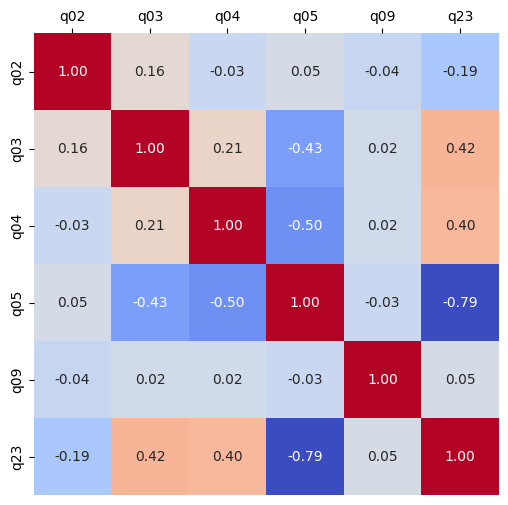

In [8]:
house_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_HouseholdInfo_clean.csv"))
correlational_matrix_heatmap(house_train, cols_to_exclude=['psu_hh_idcode', 'hhid'])

### Observations:
1. q17 and q11 are pretty highly correlated (0.88) shoudl we get rid of either one?
  
  q11(1 if mom is living in the household, 0 otherwise)
  q17(1 if dad is living in the household, 0 otherwise)

   > we decided to combine the two to create a new column q23 such that:
      q23 ( 0 if neither mom,dad live in household, 1 if one of them, 2 if both)


2. q10 has undefined variance.
   - reason: q10 only takes value 1 for all rows, so no variance. 0 variance means undefined correlation with any other variate.
   - because Correlation r between two variates X and Y:
  
  $$
  r = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}
  $$

  > we decided to get rid of this column

### Correlational Analysis: Educataion

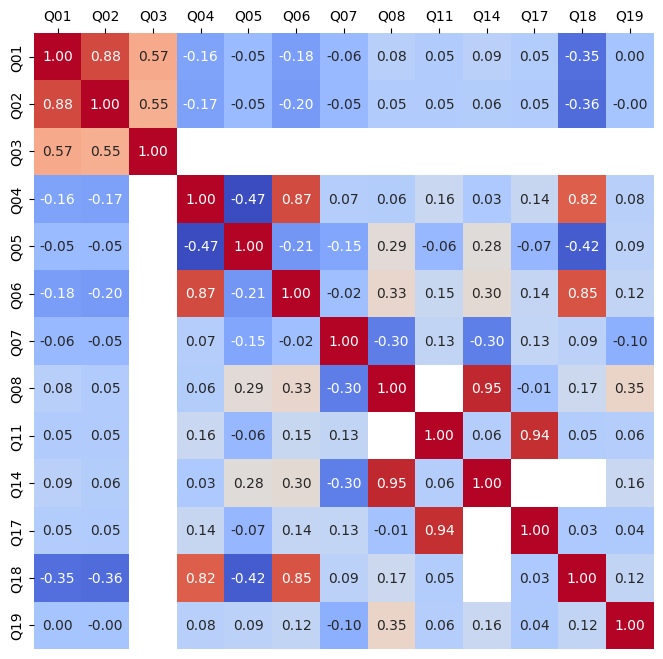

In [6]:
edu_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_Education_clean.csv"))
correlational_matrix_heatmap(edu_train, fig_size=(8,8), cols_to_exclude=['psu_hh_idcode'])

### Observations:
-
-

In [7]:
edu_train.head()

,psu_hh_idcode,Q01,Q02,Q03,Q04,Q05,Q06,Q07,Q08,Q11,Q14,Q17,Q18,Q19
0,2_8_3,1,1,1,2.0,3.0,3.0,2.0,1.0,NaN,1.0,NaN,NaN,NaN
1,3_8_4,1,1,1,2.0,2.0,2.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN
2,6_5_3,1,1,1,2.0,3.0,3.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN
3,7_7_3,1,1,1,6.0,1.0,3.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN
4,16_2_4,1,1,1,5.0,3.0,2.0,4.0,1.0,NaN,1.0,NaN,NaN,NaN
